In [30]:
# importing dependencies
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import plotly.graph_objs as go
import plotly.offline as py

# Train-Test split is 80-20, respectively. Data has been broken into two .csv files for this split.

In [31]:
# read in CSV data
df_test = pd.read_csv('C:/Users/sweir/OneDrive/Desktop/Analysis Projects/Crude_Oil_Price_Projection/ML Resources/Cleaned_Crude_Oil_Dataset_Test.csv')
df_train= pd.read_csv('C:/Users/sweir/OneDrive/Desktop/Analysis Projects/Crude_Oil_Price_Projection/ML Resources/Cleaned_Crude_Oil_Dataset_Train.csv')
df = df_train
df_train

,Date,"Cushing, OK Crude Oil Future Contract ($/Bar.)",U.S. Field Production of Crude Oil (1k Bar.),Product Supplied of Crude Oil and Petroleum Products (1k Bar.),Gross Inputs to Refineries (1k Bar./Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operating Crude Oil Distillation Capacity (1k Bar./Day),Idle Crude Oil Distillation Capacity (1k Bar./Day),Percent Utilization of Refinery Operable Capacity,"Cushing, OK WTI Spot Price FOB ($/Bar.)"
0,1/1/1986,23.0,283248,498728,12583,15459,14639,820,81.4,22.9
1,2/1/1986,15.5,256855,453209,12068,15485,14538,947,77.9,15.5
2,3/1/1986,12.6,279413,504565,11759,15485,14517,968,75.9,12.6
3,4/1/1986,12.8,265917,478339,12603,15473,14550,923,81.5,12.8
4,5/1/1986,15.3,273964,495789,13314,15484,14805,679,86.0,15.4
...,...,...,...,...,...,...,...,...,...,...
339,4/1/2014,102.0,255795,565032,16264,17951,17725,226,90.6,102.1
340,5/1/2014,101.8,267996,576636,16197,17951,17453,498,90.2,102.2
341,6/1/2014,105.1,262288,566345,16087,17825,17579,246,90.3,105.8
342,7/1/2014,102.4,274131,596659,16880,17835,17678,157,94.7,103.6


In [32]:
# viewing datatypes
df.dtypes

Date                                                                object
Cushing, OK Crude Oil Future Contract ($/Bar.)                     float64
U.S. Field Production of Crude Oil (1k Bar.)                         int64
Product Supplied of Crude Oil and Petroleum Products (1k Bar.)       int64
Gross Inputs to Refineries (1k Bar./Day)                             int64
Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)      int64
Operating Crude Oil Distillation Capacity (1k Bar./Day)              int64
Idle Crude Oil Distillation Capacity (1k Bar./Day)                   int64
Percent Utilization of Refinery Operable Capacity                  float64
Cushing, OK WTI Spot Price FOB ($/Bar.)                            float64
dtype: object

In [33]:
# to convert the date column to type DATETIME
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [34]:
# retrieving number of observations
len(df_train)

344

In [35]:
len(df_test)

86

In [36]:
# renaming columns to fit naming conventions of prophet
df_train.rename(columns={'Date': 'ds', 'Cushing, OK Crude Oil Future Contract ($/Bar.)': 'y', 'U.S. Field Production of Crude Oil (1k Bar.)': 'total_production', 'Product Supplied of Crude Oil and Petroleum Products (1k Bar.)': 'product_supplied', 'Percent Utilization of Refinery Operable Capacity': 'operable_capacity_utilization' }, inplace=True)
df_test.rename(columns={'Date': 'ds', 'Cushing, OK Crude Oil Future Contract ($/Bar.)': 'y', 'U.S. Field Production of Crude Oil (1k Bar.)': 'total_production', 'Product Supplied of Crude Oil and Petroleum Products (1k Bar.)': 'product_supplied', 'Percent Utilization of Refinery Operable Capacity': 'operable_capacity_utilization' }, inplace=True)


In [37]:
# confirming column name changes
df_train.dtypes

ds                                                                 datetime64[ns]
y                                                                         float64
total_production                                                            int64
product_supplied                                                            int64
Gross Inputs to Refineries (1k Bar./Day)                                    int64
Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)             int64
Operating Crude Oil Distillation Capacity (1k Bar./Day)                     int64
Idle Crude Oil Distillation Capacity (1k Bar./Day)                          int64
operable_capacity_utilization                                             float64
Cushing, OK WTI Spot Price FOB ($/Bar.)                                   float64
dtype: object

In [42]:
# creating a copy of un-transformed Futures Prices
df_train_orig = df_train
df_train_orig

,ds,y,total_production,product_supplied,Gross Inputs to Refineries (1k Bar./Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operating Crude Oil Distillation Capacity (1k Bar./Day),Idle Crude Oil Distillation Capacity (1k Bar./Day),operable_capacity_utilization,"Cushing, OK WTI Spot Price FOB ($/Bar.)"
0,1986-01-01,23.0,283248,498728,12583,15459,14639,820,81.4,22.9
1,1986-02-01,15.5,256855,453209,12068,15485,14538,947,77.9,15.5
2,1986-03-01,12.6,279413,504565,11759,15485,14517,968,75.9,12.6
3,1986-04-01,12.8,265917,478339,12603,15473,14550,923,81.5,12.8
4,1986-05-01,15.3,273964,495789,13314,15484,14805,679,86.0,15.4
...,...,...,...,...,...,...,...,...,...,...
339,2014-04-01,102.0,255795,565032,16264,17951,17725,226,90.6,102.1
340,2014-05-01,101.8,267996,576636,16197,17951,17453,498,90.2,102.2
341,2014-06-01,105.1,262288,566345,16087,17825,17579,246,90.3,105.8
342,2014-07-01,102.4,274131,596659,16880,17835,17678,157,94.7,103.6


In [43]:
df_train_orig.rename(columns={'y': 'y_orig'}, inplace=True)

In [10]:
df.head()

,ds,y,total_production,product_supplied,Gross Inputs to Refineries (1k Bar./Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operating Crude Oil Distillation Capacity (1k Bar./Day),Idle Crude Oil Distillation Capacity (1k Bar./Day),operable_capacity_utilization,"Cushing, OK WTI Spot Price FOB ($/Bar.)"
0,1986-01-01,23.0,283248,498728,12583,15459,14639,820,81.4,22.9
1,1986-02-01,15.5,256855,453209,12068,15485,14538,947,77.9,15.5
2,1986-03-01,12.6,279413,504565,11759,15485,14517,968,75.9,12.6
3,1986-04-01,12.8,265917,478339,12603,15473,14550,923,81.5,12.8
4,1986-05-01,15.3,273964,495789,13314,15484,14805,679,86.0,15.4


In [11]:
# logarithmic transformation to make data stationary
df_train['y'] = np.log(df_train['y'])
df_train.head()

,ds,y,total_production,product_supplied,Gross Inputs to Refineries (1k Bar./Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operating Crude Oil Distillation Capacity (1k Bar./Day),Idle Crude Oil Distillation Capacity (1k Bar./Day),operable_capacity_utilization,"Cushing, OK WTI Spot Price FOB ($/Bar.)"
0,1986-01-01,3.135494,283248,498728,12583,15459,14639,820,81.4,22.9
1,1986-02-01,2.740840,256855,453209,12068,15485,14538,947,77.9,15.5
2,1986-03-01,2.533697,279413,504565,11759,15485,14517,968,75.9,12.6
3,1986-04-01,2.549445,265917,478339,12603,15473,14550,923,81.5,12.8
4,1986-05-01,2.727853,273964,495789,13314,15484,14805,679,86.0,15.4


In [12]:
# building the model 
m = Prophet(seasonality_mode='multiplicative')
m.add_regressor('Operating Crude Oil Distillation Capacity (1k Bar./Day)')
m.add_regressor('Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)')

In [13]:
# fit model, building out future dataframe and setting prediction parameters
m.fit(df_train)

future_data = m.make_future_dataframe(periods=12,freq='M')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future_data.head()

,ds
0,1986-01-01
1,1986-02-01
2,1986-03-01
3,1986-04-01
4,1986-05-01


In [15]:
df = df.append(df_test)
df = df.rename(columns={'Cushing, OK Crude Oil Future Contract ($/Bar.)': 'y', 'date':'ds'})
future_data = df[['ds', 'Operating Crude Oil Distillation Capacity (1k Bar./Day)', 'Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)']]

In [16]:
forecast_data = m.predict(future_data)
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)_lower,Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)_upper,Operating Crude Oil Distillation Capacity (1k Bar./Day),...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1986-01-01,2.876775,2.505421,2.986577,2.876775,2.876775,-0.046200,-0.046200,-0.046200,0.012671,...,-0.045105,-0.045105,-0.045105,-0.011575,-0.011575,-0.011575,0.0,0.0,0.0,2.747018
1,1986-02-01,2.880914,2.509165,2.954964,2.880914,2.880914,-0.044979,-0.044979,-0.044979,0.013605,...,-0.051081,-0.051081,-0.051081,-0.019708,-0.019708,-0.019708,0.0,0.0,0.0,2.733752
2,1986-03-01,2.884652,2.518521,3.005873,2.884652,2.884652,-0.044979,-0.044979,-0.044979,0.013799,...,-0.045317,-0.045317,-0.045317,-0.014137,-0.014137,-0.014137,0.0,0.0,0.0,2.753929
3,1986-04-01,2.888791,2.550215,3.020318,2.888791,2.888791,-0.045543,-0.045543,-0.045543,0.013494,...,-0.036662,-0.036662,-0.036662,-0.004613,-0.004613,-0.004613,0.0,0.0,0.0,2.782884
4,1986-05-01,2.892797,2.553473,3.038057,2.892797,2.892797,-0.045026,-0.045026,-0.045026,0.011135,...,-0.034586,-0.034586,-0.034586,-0.000695,-0.000695,-0.000695,0.0,0.0,0.0,2.792747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2021-06-01,4.780412,4.729659,5.387907,4.577141,4.971108,0.079182,0.079182,0.079182,-0.017584,...,0.057986,0.057986,0.057986,-0.003612,-0.003612,-0.003612,0.0,0.0,0.0,5.057609
426,2021-07-01,4.784390,4.738347,5.371747,4.577091,4.977595,0.079229,0.079229,0.079229,-0.017889,...,0.059045,0.059045,0.059045,-0.002295,-0.002295,-0.002295,0.0,0.0,0.0,5.066885
427,2021-08-01,4.788502,4.790830,5.440348,4.577324,4.983893,0.079276,0.079276,0.079276,-0.017621,...,0.067284,0.067284,0.067284,0.005629,0.005629,0.005629,0.0,0.0,0.0,5.110691
428,2021-09-01,4.792613,4.860109,5.531860,4.576603,4.992973,0.079276,0.079276,0.079276,0.001932,...,0.087117,0.087117,0.087117,0.005908,0.005908,0.005908,0.0,0.0,0.0,5.210128


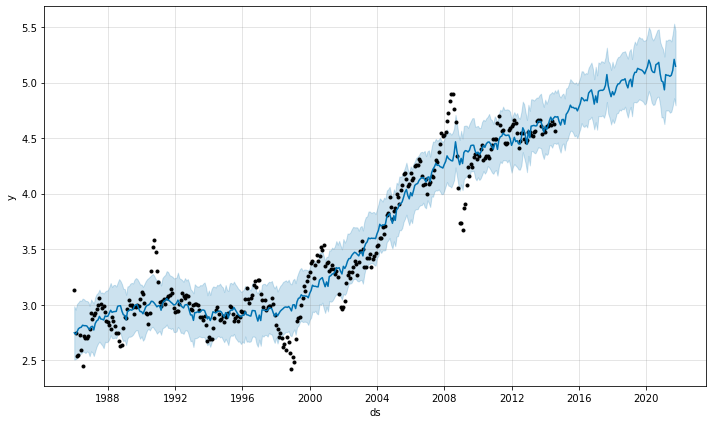

In [17]:
#initial visualization of model results
model_visualization = m.plot(forecast_data)

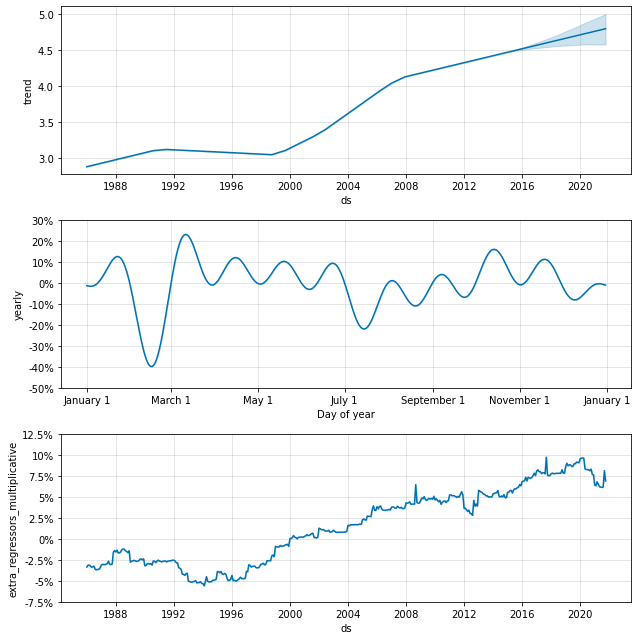

In [18]:
# plotting forecast components
forecast_components = m.plot_components(forecast_data)

In [19]:
# saving transformed forecast data
forecast_data_original = forecast_data 

# reversing logarithmic transformation for real price predications
forecast_data_original['yhat'] = np.exp(forecast_data_original['yhat'])
forecast_data_original['yhat_lower'] = np.exp(forecast_data_original['yhat_lower'])
forecast_data_original['yhat_upper'] = np.exp(forecast_data_original['yhat_upper'])

In [ ]:
forecast_

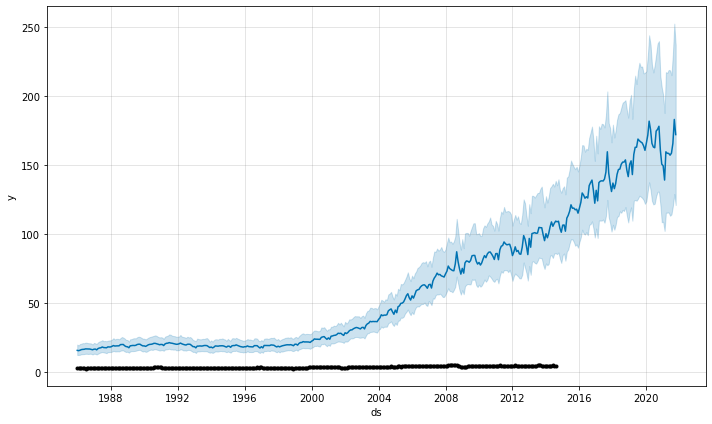

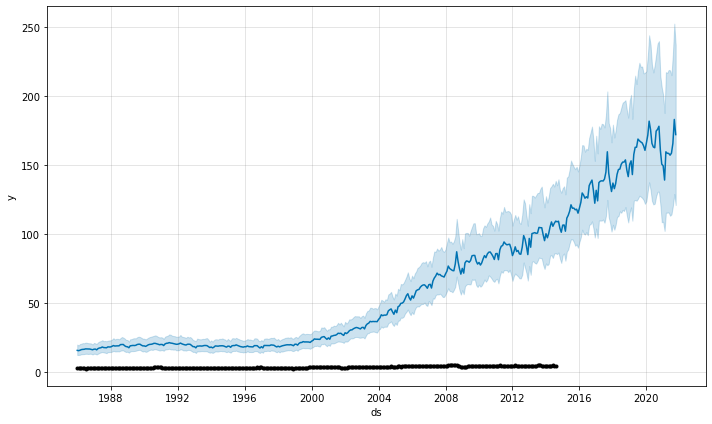

In [20]:
# plotting real price forecasts
m.plot(forecast_data_original)


In [21]:
#comparing initial projections to test data
df_crossval = cross_validation(m, initial='1825 days', period='180 days', horizon = '365 days')
df_crossval.head()

df_mtrcs = performance_metrics(df_crossval)
df_mtrcs.head()

INFO:prophet:Making 46 forecasts with cutoffs between 1991-05-29 00:00:00 and 2013-08-01 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.062071,0.249140,0.197490,0.056621,0.048333,0.055993,0.618182
1,38 days,0.061873,0.248742,0.196954,0.056907,0.048365,0.056231,0.600000
2,39 days,0.061139,0.247264,0.193754,0.055870,0.042018,0.055185,0.612121
3,40 days,0.064182,0.253341,0.201164,0.058189,0.048365,0.057315,0.581818
4,41 days,0.064711,0.254384,0.203613,0.058832,0.049083,0.057984,0.581818


In [22]:
df_mtrcs

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.062071,0.249140,0.197490,0.056621,0.048333,0.055993,0.618182
1,38 days,0.061873,0.248742,0.196954,0.056907,0.048365,0.056231,0.600000
2,39 days,0.061139,0.247264,0.193754,0.055870,0.042018,0.055185,0.612121
3,40 days,0.064182,0.253341,0.201164,0.058189,0.048365,0.057315,0.581818
4,41 days,0.064711,0.254384,0.203613,0.058832,0.049083,0.057984,0.581818
...,...,...,...,...,...,...,...,...
266,360 days,0.088912,0.298181,0.228904,0.065504,0.043769,0.065722,0.572727
267,361 days,0.088682,0.297794,0.229477,0.065341,0.043769,0.065526,0.563636
268,363 days,0.091520,0.302522,0.236040,0.067457,0.047069,0.067766,0.545455
269,364 days,0.091093,0.301817,0.233779,0.066986,0.047069,0.067305,0.545455


In [23]:
# Calculate mean absolute percentage error (MAPE)
mape_avg = np.mean(100 * (df_mtrcs['mape']))
avg_accuracy = 100 - mape_avg

print("Accuracy:", round(avg_accuracy, 2), "%.")

Accuracy: 93.33 %.


In [62]:
# creating final df
final_df = forecast_data_original

yorig = df_train_orig['y_orig']
final_df = final_df.join(yorig)

In [86]:
final_df.reset_index()

,index,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)_lower,Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)_upper,...,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y_orig
0,0,1986-01-01,2.876775,12.248717,19.817728,2.876775,2.876775,-0.046200,-0.046200,-0.046200,...,-0.045105,-0.045105,-0.011575,-0.011575,-0.011575,0.0,0.0,0.0,15.596060,23.0
1,1,1986-02-01,2.880914,12.294658,19.201032,2.880914,2.880914,-0.044979,-0.044979,-0.044979,...,-0.051081,-0.051081,-0.019708,-0.019708,-0.019708,0.0,0.0,0.0,15.390532,15.5
2,2,1986-03-01,2.884652,12.410225,20.203845,2.884652,2.884652,-0.044979,-0.044979,-0.044979,...,-0.045317,-0.045317,-0.014137,-0.014137,-0.014137,0.0,0.0,0.0,15.704216,12.6
3,3,1986-04-01,2.888791,12.809859,20.497804,2.888791,2.888791,-0.045543,-0.045543,-0.045543,...,-0.036662,-0.036662,-0.004613,-0.004613,-0.004613,0.0,0.0,0.0,16.165569,12.8
4,4,1986-05-01,2.892797,12.851658,20.864657,2.892797,2.892797,-0.045026,-0.045026,-0.045026,...,-0.034586,-0.034586,-0.000695,-0.000695,-0.000695,0.0,0.0,0.0,16.325807,15.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,425,2021-06-01,4.780412,113.256989,218.745069,4.577141,4.971108,0.079182,0.079182,0.079182,...,0.057986,0.057986,-0.003612,-0.003612,-0.003612,0.0,0.0,0.0,157.214130,NaN
426,426,2021-07-01,4.784390,114.245233,215.238549,4.577091,4.977595,0.079229,0.079229,0.079229,...,0.059045,0.059045,-0.002295,-0.002295,-0.002295,0.0,0.0,0.0,158.679212,NaN
427,427,2021-08-01,4.788502,120.401301,230.522364,4.577324,4.983893,0.079276,0.079276,0.079276,...,0.067284,0.067284,0.005629,0.005629,0.005629,0.0,0.0,0.0,165.784838,NaN
428,428,2021-09-01,4.792613,129.038327,252.613357,4.576603,4.992973,0.079276,0.079276,0.079276,...,0.087117,0.087117,0.005908,0.005908,0.005908,0.0,0.0,0.0,183.117557,NaN


ds                                                                       datetime64[ns]
trend                                                                           float64
yhat_lower                                                                      float64
yhat_upper                                                                      float64
trend_lower                                                                     float64
trend_upper                                                                     float64
Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)                 float64
Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)_lower           float64
Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)_upper           float64
Operating Crude Oil Distillation Capacity (1k Bar./Day)                         float64
Operating Crude Oil Distillation Capacity (1k Bar./Day)_lower                   float64
Operating Crude Oil Distillation

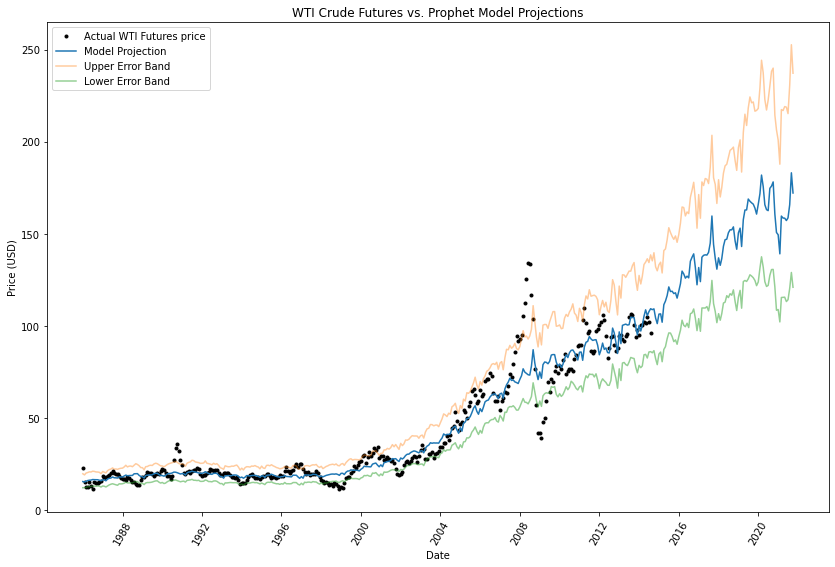

In [98]:
# Plot the actual values
plt.rcParams["figure.figsize"] = (14,9)
plt.plot(final_df['ds'], final_df['y_orig'], "o", color='k', markersize=3, label = "Actual WTI Futures price")

# Plot the predicted values
plt.plot(final_df['ds'], final_df['yhat'], ls="-", markersize=1, label = "Model Projection")
plt.xticks(rotation = "60"); 


# Plot Error Bands
plt.plot(final_df['ds'], final_df['yhat_upper'], ls="-", markersize=1, label = "Upper Error Band", alpha=0.4)
plt.plot(final_df['ds'], final_df['yhat_lower'], ls="-", markersize=1, label = "Lower Error Band",  alpha=0.5)
plt.legend()
# Graph labels
plt.xlabel("Date"); plt.ylabel("Price (USD)"); plt.title('WTI Crude Futures vs. Prophet Model Projections');